In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán Walmart market và chia train test validate theo tỉ lệ 7:1:2
# Load the dataset
data_url = 'https://raw.githubusercontent.com/minknhom/dataset/main/walmart_stock_price.csv'
df = pd.read_csv(data_url)


df['Date'] = pd.to_datetime(df['Date'])
start_date =  pd.to_datetime('2010-01-01')
end_date =  pd.to_datetime('2022-12-31')
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))
# val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
# val_data = df[train_size+test_size:]

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6164.118, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6161.910, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6159.373, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6159.198, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6162.256, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6160.122, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6160.394, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6162.117, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6159.771, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.232 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [4]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[118.69696849 118.72326568 118.74956287 118.77586006 118.80215725
 118.82845443 118.85475162 118.88104881 118.907346   118.93364319
 118.95994038 118.98623757 119.01253475 119.03883194 119.06512913
 119.09142632 119.11772351 119.1440207  119.17031789 119.19661507
 119.22291226 119.24920945 119.27550664 119.30180383 119.32810102
 119.35439821 119.38069539 119.40699258 119.43328977 119.45958696]


In [6]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_error

# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Calculate the Mean Absolute Percentage Error (MAPE)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test) * 100)

# Mean Absolute Error (MAE)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print("Test MAPE:", test_mape)
print("Test MAE:", test_mae)

Testing RMSE: 11.101305154346058
Test MAPE: 6.471012735741503
Test MAE: 9.038786628078745


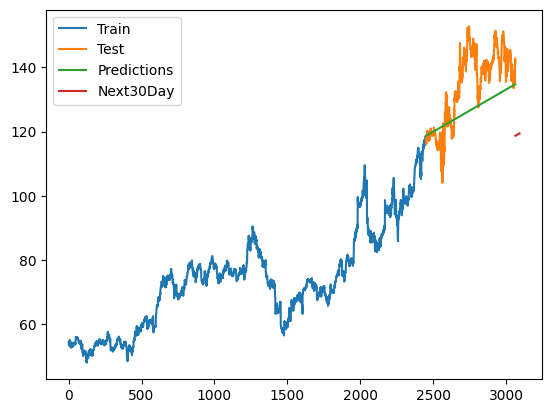

In [7]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
# plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred)
# plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()